In [2]:
import json
from PIL import Image
import os
import gc
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import clip
from pytorch_metric_learning import losses

/home/pyt_user/miniconda3/envs/clip_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
in_dir = "/mnt/nis_lab_research/data/clip_data/far_shah_b1-b5_b8_train_neg"

In [4]:
cuda_device_id = 3
torch.cuda.set_device(cuda_device_id)
torch.cuda.get_device_name(cuda_device_id)

'Tesla P40'

In [5]:
torch.cuda.empty_cache()
gc.collect()

11

In [6]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device(f"cuda:{cuda_device_id}")
model = model.to(device)

In [8]:
print(model)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [9]:
# img_path_list = []
# txt_list = []

# for d in sorted(os.listdir(in_dir)):
#     path1 = os.path.join(in_dir, d)
#     for f in sorted(os.listdir(path1)):
#         path2 = os.path.join(path1, f)
#         if f[-4:] == ".txt":
#             with open(path2, "r") as file:
#                 text = file.read().lower()
#             full_text = d + ": " + text
#             full_text = full_text.lower()
#             txt_list.append(full_text[:77])
#         elif f[-4:] == ".png":
#             img_path_list.append(path2)
#         else:
#             print("file extension not supported")
#             exit()


img_path_list = []
txt_list = []

for d in sorted(os.listdir(in_dir)):
    path1 = os.path.join(in_dir, d)
    for f in sorted(os.listdir(path1)):
        path2 = os.path.join(path1, f)
        if f[-4:] == ".txt":
            label = d
            label = label.lower()
            txt_list.append(label[:77])
        elif f[-4:] == ".png":
            img_path_list.append(path2)
        else:
            print("file extension not supported")
            exit()
            

In [10]:
img_path_list[0:5]

['/mnt/nis_lab_research/data/clip_data/far_shah_b1-b5_b8_train_neg/Accept Button/003yJtw0HOcO1Kwu-smartvault_ss-84446.png',
 '/mnt/nis_lab_research/data/clip_data/far_shah_b1-b5_b8_train_neg/Accept Button/05OQiy0I3CiuanjK-macship_ss-55496.png',
 '/mnt/nis_lab_research/data/clip_data/far_shah_b1-b5_b8_train_neg/Accept Button/0FX4MgBuXfPglIaX-bakerbotts_ss-133599.png',
 '/mnt/nis_lab_research/data/clip_data/far_shah_b1-b5_b8_train_neg/Accept Button/0HUXuMTPIiPWGUrE-mercedes-benz_ss-18212.png',
 '/mnt/nis_lab_research/data/clip_data/far_shah_b1-b5_b8_train_neg/Accept Button/0NhUCX7Yj5e9pA84-abchosts_ss-29834.png']

In [11]:
txt_list[0:5]

['accept button',
 'accept button',
 'accept button',
 'accept button',
 'accept button']

In [12]:
class web_elem_dataset():
    def __init__(self, list_image_path, list_path):

        self.image_path = list_image_path
        self.context  = clip.tokenize(list_path)

    def __len__(self):
        return len(self.context)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        context = self.context[idx]
        
        return image, context

In [13]:
dataset = web_elem_dataset(img_path_list, txt_list)

In [14]:
train_dataloader = DataLoader(dataset, batch_size=150, num_workers=10, shuffle=True) #Define your own dataloader

In [15]:
# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [16]:
# Prepare the optimizer
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-5,         
    betas=(0.9, 0.999),  
    eps=1e-8,        
    weight_decay=0.01
)  

In [17]:
# # Specify the loss function
# loss_img = nn.CrossEntropyLoss()
# loss_txt = nn.CrossEntropyLoss()

In [18]:
# def contrastive_loss(image_features, text_features, temperature=1):
#     # Normalize features to unit length
#     image_features = F.normalize(image_features, p=2, dim=1)
#     text_features = F.normalize(text_features, p=2, dim=1)
    
#     # Compute logits
#     logits = torch.matmul(image_features, text_features.t()) / temperature
#     labels = torch.arange(logits.shape[0]).to(logits.device)
    
#     # Calculate loss for both image-to-text and text-to-image
#     loss_i2t = F.cross_entropy(logits, labels)
#     loss_t2i = F.cross_entropy(logits.t(), labels)
    
#     # Symmetric loss
#     return (loss_i2t + loss_t2i) / 2

In [19]:
# # Training
# num_epochs = 30
# for i, epoch in enumerate(range(num_epochs)):
#     pbar = tqdm(train_dataloader, total=len(train_dataloader))
#     for images, texts in pbar:
#         optimizer.zero_grad()
#         images = images.to(device)
#         texts = texts.to(device)
        
#         logits_per_image, logits_per_text = model(images, texts)
#         # total_loss = contrastive_loss(logits_per_image, logits_per_text)
        
#         ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
#         total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2

#         total_loss.backward()
#         convert_models_to_fp32(model)
#         optimizer.step()
#         clip.model.convert_weights(model)
        
#         pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")
        
#         with open('./checkpoints/training_output.txt', 'a') as f:
#             f.write(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}\n")

#     torch.save(model, f"./checkpoints/ckpt_e{i}.pth")

In [20]:
contrastive_loss = losses.ContrastiveLoss()

In [21]:
# Training
num_epochs = 30
for i, epoch in enumerate(range(num_epochs)):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for images, texts in pbar:
        optimizer.zero_grad()
        images = images.to(device)
        texts = texts.to(device)
        
        logits_per_image, logits_per_text = model(images, texts)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (contrastive_loss(logits_per_image, ground_truth) + contrastive_loss(logits_per_text, ground_truth)) / 2

        total_loss.backward()
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)
        
        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")
        
        with open('./checkpoints/training_output.txt', 'a') as f:
            f.write(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}\n")

    torch.save(model, f"./checkpoints/ckpt_e{i}.pth")

  0%|          | 0/1866 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.5801:  20%|█▉        | 372/1866 [14:29<58:11,  2.34s/it]  


KeyboardInterrupt: 

In [ ]:
f = open('./checkpoints/training_output.txt', 'w+')
f.close()

In [ ]:
torch.save(model, "./model_final.pth")
torch.save(model.state_dict(), "./model_final_sd.pth")

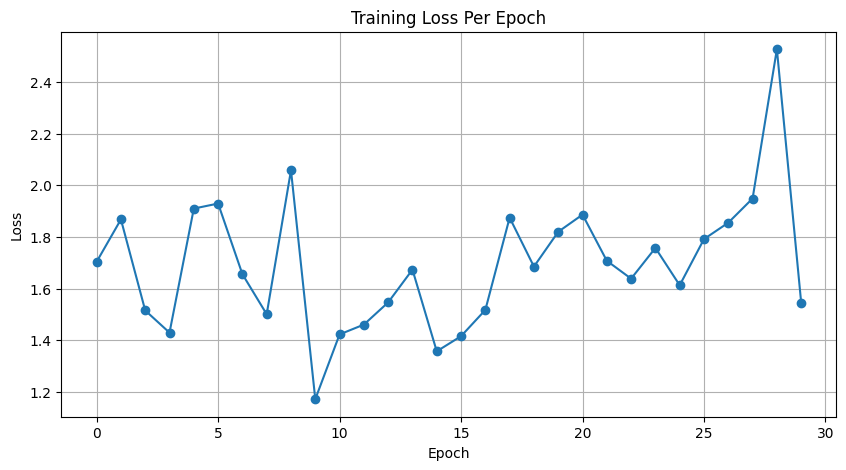

In [ ]:
epochs = []
losses = []

# Regular expression to capture the epoch number and loss
pattern = re.compile(r"Epoch (\d+)/30, Loss: ([\d\.]+):")

with open("./checkpoints/training_output.txt", 'r') as file:
    for line in file:
        match = pattern.search(line)
        if match:
            epoch = int(match.group(1))
            loss = float(match.group(2))
            epochs.append(epoch)
            losses.append(loss)
            
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()